In [1]:
import os

os.environ['KMP_DUPLICATE_LIB_OK']='True'

import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.autograd import Function
from torchvision import datasets, models, transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import qiskit
from qiskit.visualization import *

# Preprocessing Dataset

## Move image into one folder

In [2]:
import shutil

IMAGE_PATH = 'C:/Users/10907026/Desktop/project/qiskit/cat_dog_dataset/'
train_cat_path = IMAGE_PATH + "cat/"
train_dog_path = IMAGE_PATH + "dog/"

if not os.path.isdir(IMAGE_PATH):
    os.mkdir(IMAGE_PATH)
if not os.path.isdir(train_cat_path):
    os.mkdir(train_cat_path)
if not os.path.isdir(train_dog_path):
    os.mkdir(train_dog_path)
    
ori_cat_path = 'C:/Users/10907026/Desktop/project/qiskit/dataset/cat/'
ori_dog_path = 'C:/Users/10907026/Desktop/project/qiskit/dataset/dog/'
cat_img = os.listdir(ori_cat_path)
dog_img = os.listdir(ori_dog_path)

for name in cat_img:
    shutil.copyfile(ori_cat_path + name, train_cat_path + name)
    
for name in dog_img:
    shutil.copyfile(ori_dog_path + name, train_dog_path + name)


## Loading Data

### Set 70% data for training and 30% data for testing

In [3]:
TRAIN_PATH = 'C:/Users/10907026/Desktop/project/qiskit/cat_dog_dataset'

data_transform = transforms.Compose([transforms.Resize([224,224]),
                                     transforms.ToTensor()])

X_train = datasets.ImageFolder(root=TRAIN_PATH, 
                               transform=data_transform)

train_size = int(0.7 * len(X_train))
test_size = len(X_train) - train_size
x_train, X_test = torch.utils.data.random_split(X_train, [train_size, test_size])

### Set Batch Size

In [4]:
b = 1

train_loader = torch.utils.data.DataLoader(X_train, batch_size=b, shuffle=True)
test_loader = torch.utils.data.DataLoader(X_test, batch_size=b, shuffle=True)

## Create NN Module

Since image is RGB (3 channels), change Conv2d to 3

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=11)
        self.dropout = nn.Dropout2d()
        self.fc1 = nn.Linear(20000, 16)
        self.fc2 = nn.Linear(16, 2) # why????
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

## Start Training

In [6]:
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()

epochs = 10
loss_list = []

model.train()
for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        total_loss.append(loss.item())
    loss_list.append(sum(total_loss)/len(total_loss))
    print('Training [{:.0f}%]\tLoss: {:.4f}'.format(
        100. * (epoch + 1) / epochs, loss_list[-1]))

Training [10%]	Loss: 0.6438
Training [20%]	Loss: 0.6312
Training [30%]	Loss: 0.6307
Training [40%]	Loss: 0.6309
Training [50%]	Loss: 0.6309
Training [60%]	Loss: 0.6305
Training [70%]	Loss: 0.6308
Training [80%]	Loss: 0.6307
Training [90%]	Loss: 0.6308
Training [100%]	Loss: 0.6302


Text(0, 0.5, 'Neg Log Likelihood Loss')

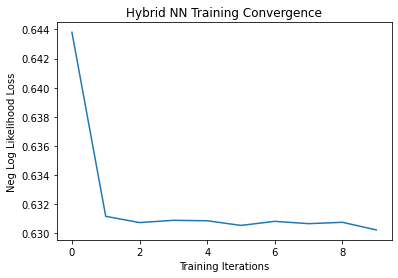

In [7]:
plt.plot(loss_list)
plt.title('Hybrid NN Training Convergence')
plt.xlabel('Training Iterations')
plt.ylabel('Neg Log Likelihood Loss')

In [8]:
model.eval()
with torch.no_grad():
    
    correct = 0
    val_total = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        val_total += data.size(0)
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / val_total * 100)
        )

Performance on test data:
	Loss: 0.6286
	Accuracy: 68.5%


In [9]:
print(correct)
print(val_total)
print(correct / val_total)

1518
2217
0.6847090663058186


In [11]:
def train(model,n_epochs,train_loader,valid_loader,optimizer,criterion):
    train_acc_his,valid_acc_his=[],[]
    train_losses_his,valid_losses_his=[],[]
    for epoch in range(1, n_epochs+1):
        # keep track of training and validation loss
        train_loss,valid_loss = 0.0,0.0
        train_losses,valid_losses=[],[]
        train_correct,val_correct,train_total,val_total=0,0,0,0
        train_pred,train_target=torch.zeros(8,1),torch.zeros(8,1)
        val_pred,val_target=torch.zeros(8,1),torch.zeros(8,1)
        count=0
        count2=0
        print('running epoch: {}'.format(epoch))
        ###################
        # train the model #
        ###################
        model.train()
        for data, target in tqdm(train_loader):
            # move tensors to GPU if CUDA is available
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            #calculate accuracy
            pred = output.data.max(dim = 1, keepdim = True)[1]
            train_correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
            train_total += data.size(0)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update training loss
            train_losses.append(loss.item()*data.size(0))
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            if count==0:
                train_pred=pred
                train_target=target.data.view_as(pred)
                count=count+1
            else:
                train_pred=torch.cat((train_pred,pred), 0)
                train_target=torch.cat((train_target,target.data.view_as(pred)), 0)
        train_pred=train_pred.cpu().view(-1).numpy().tolist()
        train_target=train_target.cpu().view(-1).numpy().tolist()
        ######################    
        # validate the model #
        ######################
        model.eval()
        for data, target in tqdm(valid_loader):
            # move tensors to GPU if CUDA is available
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss =criterion(output, target)
            #calculate accuracy
            pred = output.data.max(dim = 1, keepdim = True)[1]
            val_correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
            val_total += data.size(0)
            valid_losses.append(loss.item()*data.size(0))
            if count2==0:
                val_pred=pred
                val_target=target.data.view_as(pred)
                count2=count+1
            else:
                val_pred=torch.cat((val_pred,pred), 0)
                val_target=torch.cat((val_target,target.data.view_as(pred)), 0)
        val_pred=val_pred.cpu().view(-1).numpy().tolist()
        val_target=val_target.cpu().view(-1).numpy().tolist()
        
        # calculate average losses
        train_loss=np.average(train_losses)
        valid_loss=np.average(valid_losses)
        
        # calculate average accuracy
        train_acc=train_correct/train_total
        valid_acc=val_correct/val_total
train_acc_his.append(train_acc)
        valid_acc_his.append(valid_acc)
        train_losses_his.append(train_loss)
        valid_losses_his.append(valid_loss)
# print training/validation statistics 
        print('\tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            train_loss, valid_loss))
        print('\tTraining Accuracy: {:.6f} \tValidation Accuracy: {:.6f}'.format(
            train_acc, valid_acc))
    return train_acc_his,valid_acc_his,train_losses_his,valid_losses_his,model

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 90)

In [ ]:
model1=CNN_Model()
n_epochs = 10
optimizer1 = torch.optim.Adam(model1.parameters(), lr=LR)
criterion = CrossEntropyLoss()
train_acc_his,valid_acc_his,train_losses_his,valid_losses_his,model1=train(model1,n_epochs,train_loader,valid_loader,optimizer1,criterion)